## **VAD Testing**

**utils_vad.py**

In [ ]:
'''
vad.py from WhisperLive similar to utils_vad.py from sliero-vad
https://github.com/snakers4/silero-vad. See vad.py from WhisperLive
https://github.com/snakers4/silero-vad/discussions/201
https://www.reddit.com/r/MachineLearning/comments/rj67dz/p_silero_vad_one_voice_detector_to_rule_them_all/?rdt=48974


utils_vad.py
threshold: float (default - 0.5)
Speech threshold. Silero VAD outputs speech probabilities for each audio chunk, probabilities ABOVE this value are considered as SPEECH.
It is better to tune this parameter for each dataset separately, but "lazy" 0.5 is pretty good for most datasets

neg_threshold: float (default = threshold - 0.15)
Negative threshold (noise or exit threshold). If model's current state is SPEECH, values BELOW this value are considered as NON-SPEECH.

window_size_samples = 512 if sampling_rate == 16000 else 256
for current_start_sample in range(0, audio_length_samples, window_size_samples):
    chunk = audio[current_start_sample: current_start_sample + window_size_samples]
    if len(chunk) < window_size_samples:
        chunk = torch.nn.functional.pad(chunk, (0, int(window_size_samples - len(chunk))))
    speech_prob = model(chunk, sampling_rate).item()

speech_prob >= threshold

x is an audio chunk
speech_prob = self.model(x, self.sampling_rate).item()


speech_prob = self.model(x, self.sampling_rate).item()
- VAD itself returns a bool value for a given audio chunk
'''

**colab_record_example.ipynb**

In [ ]:
'''
model, _ = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True)


s = output.eval_js("data")
b = b64decode(s.split(',')[1])
audio = AudioSegment.from_file(BytesIO(b))
audio.export('test.mp3', format='mp3')
audio = audio.set_channels(1)
audio = audio.set_frame_rate(16000)
audio_float = int2float(audio)
tensor = torch.tensor(audio_float)


speech_probs = model.audio_forward(tensor, sr=16000)[0].tolist()
'''

**microphone_and_webRTC_integration.py**

In [ ]:
'''
model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                                    model=ARGS.silaro_model_name,
                                    force_reload= ARGS.reload)

(get_speech_ts,_,_, _,_, _, _) = utils

time_stamps = get_speech_ts(audio_float32, model,num_steps=ARGS.num_steps,trig_sum=ARGS.trig_sum,neg_trig_sum=ARGS.neg_trig_sum,
                                    num_samples_per_window=ARGS.num_samples_per_window,min_speech_samples=ARGS.min_speech_samples,
                                    min_silence_samples=ARGS.min_silence_samples)

if(len(time_stamps)>0):
    print("silero VAD has detected a possible speech")
else:
    print("silero VAD has detected a noise")
'''

**pyaudio-streaming-examples.ipynb**

In [ ]:
'''
The following example reads the audio as 250ms chunks from the microphone, 
converts them to a Pytorch Tensor, and gets the probabilities/confidences 
if the model thinks the frame is voiced.

model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True)

(get_speech_timestamps,
 save_audio,
 read_audio,
 VADIterator,
 collect_chunks) = utils


FORMAT = pyaudio.paInt16
CHANNELS = 1
SAMPLE_RATE = 16000
CHUNK = int(SAMPLE_RATE / 10)
audio = pyaudio.PyAudio()
num_samples = 512

stream = audio.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=SAMPLE_RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

print("Started Recording")
for i in range(0, frames_to_record):
    
    audio_chunk = stream.read(num_samples)
    
    # in case you want to save the audio later
    data.append(audio_chunk)
    
    audio_int16 = np.frombuffer(audio_chunk, np.int16);

    audio_float32 = int2float(audio_int16)
    
    # get the confidences and add them to the list to plot them later
    new_confidence = model(torch.from_numpy(audio_float32), 16000).item()
    voiced_confidences.append(new_confidence)
    
print("Stopped the recording")

# plot the confidences for the speech
plt.figure(figsize=(20,6))
plt.plot(voiced_confidences)
plt.show()
'''

## **Test 1: Using VAD util to detect 4096 chunk size**

Start recording
Stop recording


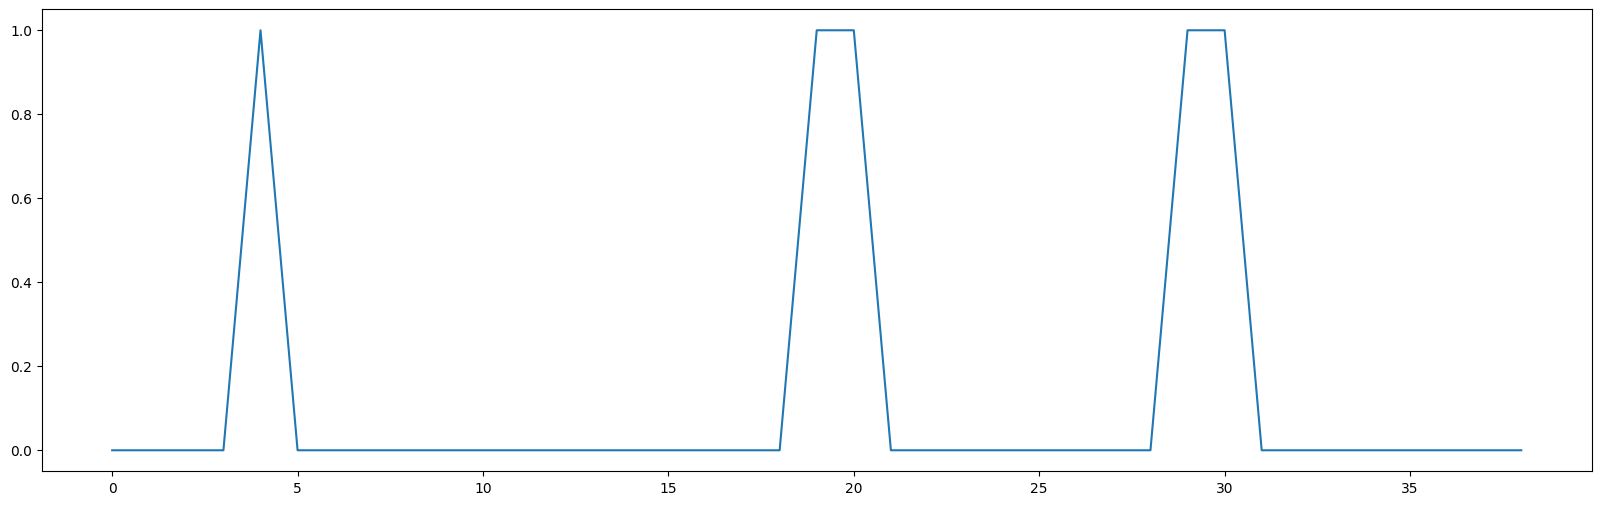

In [1]:
from silero_vad import load_silero_vad, read_audio, get_speech_timestamps
import pyaudio
import matplotlib.pylab as plt
import numpy as np
import torch
from vad import VoiceActivityDetector

# Provided by Alexander Veysov
def int2float(sound):
    abs_max = np.abs(sound).max()
    sound = sound.astype('float32')
    if abs_max > 0:
        sound *= 1/32768
    sound = sound.squeeze()  # depends on the use case
    return sound


'''
Helper function for recording audio
'''
def bytes_to_float_array(data):
    """
    Converts the given byte string to a NumPy float32 array.
    (Ensure the dtype matches your audio format.)
    """
    return np.frombuffer(data, dtype=np.float32)


# Load the Silero VAD model
vad_model_path = './silero_vad.onnx'
vad_detector = VoiceActivityDetector(vad_model_path)


# Audio recording settings
record_seconds = 10
format = pyaudio.paInt16  
channels = 1                 
rate = 16000 # number of samples taken per second
chunk = 4096 # number of samples to take per read
p = pyaudio.PyAudio() # Set up PyAudio

'''
chunk duration = chunk_size/sampling_rate

number of chunks in a single second of data = sampling_rate/chunk_size
'''

stream = p.open(
    format=format,
    channels=channels,
    rate=rate,
    input=True,
    frames_per_buffer=chunk,
)

voiced_confidences = []



print("Start recording")
# Continuously records audio data from the input stream, sends it to the server via a WebSocket connection
# Stops recording when the `RECORD_SECONDS` duration is reached 
for _ in range(0, int(rate / chunk * record_seconds)):
    # Read samples from stream
    # https://people.csail.mit.edu/hubert/pyaudio/docs/#pyaudio.PyAudio.Stream
    data = stream.read(chunk, exception_on_overflow=False)
    '''
    audio_array = bytes_to_float_array(data)
    frame_data = audio_array.tobytes()
    frame_np = np.frombuffer(frame_data, dtype=np.float32)
    '''
    # Use the VAD model and store the result
    audio_int16 = np.frombuffer(data, np.int16)
    audio_float32 = int2float(audio_int16)
    # Use the VAD model
    new_confidence = vad_detector(audio_float32)
    if new_confidence:
        voiced_confidences.append(1)
    else:
        voiced_confidences.append(0)
print("Stop recording")

plt.figure(figsize=(20,6))
plt.plot(voiced_confidences)
plt.show()


## **Test 2: Using VAD util to detect 512 samples**

In [ ]:
from silero_vad import load_silero_vad, read_audio, get_speech_timestamps
import pyaudio
import matplotlib.pylab as plt
import numpy as np
import torch
from vad import VoiceActivityDetector


# Provided by Alexander Veysov
def int2float(sound):
    abs_max = np.abs(sound).max()
    sound = sound.astype('float32')
    if abs_max > 0:
        sound *= 1/32768
    sound = sound.squeeze()  # depends on the use case
    return sound


# Load the Silero VAD model
# Load the Silero VAD model
vad_model_path = './silero_vad.onnx'
vad_detector = VoiceActivityDetector(vad_model_path)

# Audio recording settings
record_seconds = 10
format = pyaudio.paInt16  
channels = 1                 
rate = 16000 # number of frames per second
chunk = 512
p = pyaudio.PyAudio() # Set up PyAudio
num_samples = 512

stream = p.open(
    format=format,
    channels=channels,
    rate=rate,
    input=True,
    frames_per_buffer=chunk,
)

voiced_confidences = []

print("Start recording")
frames_to_record = 300
# Continuously records audio data from the input stream, sends it to the server via a WebSocket connection
# Stops recording when the `RECORD_SECONDS` duration is reached 
for _ in range(0, frames_to_record):
    # Read samples from stream
    # https://people.csail.mit.edu/hubert/pyaudio/docs/#pyaudio.PyAudio.Stream
    data = stream.read(num_samples)
    # Use the VAD model and store the result
    audio_int16 = np.frombuffer(data, np.int16)
    audio_float32 = int2float(audio_int16)
    new_confidence = vad_detector(audio_float32)
    voiced_confidences.append(new_confidence)
print("Stop recording")

plt.figure(figsize=(20,6))
plt.plot(voiced_confidences)
plt.show()


## **Test 3: Using VAD model to detect 512 samples**

In [ ]:
from silero_vad import load_silero_vad, read_audio, get_speech_timestamps
import pyaudio
import matplotlib.pylab as plt
import numpy as np
import torch


# Provided by Alexander Veysov
def int2float(sound):
    abs_max = np.abs(sound).max()
    sound = sound.astype('float32')
    if abs_max > 0:
        sound *= 1/32768
    sound = sound.squeeze()  # depends on the use case
    return sound


# Load the Silero VAD model
model = load_silero_vad()

# Audio recording settings
record_seconds = 10
format = pyaudio.paInt16  
channels = 1                 
rate = 16000 # number of frames per second
chunk = 512
p = pyaudio.PyAudio() # Set up PyAudio
num_samples = 512

stream = p.open(
    format=format,
    channels=channels,
    rate=rate,
    input=True,
    frames_per_buffer=chunk,
)

voiced_confidences = []

print("Start recording")
frames_to_record = 150
# Continuously records audio data from the input stream, sends it to the server via a WebSocket connection
# Stops recording when the `RECORD_SECONDS` duration is reached 
for _ in range(0, frames_to_record):
    # Read samples from stream
    # https://people.csail.mit.edu/hubert/pyaudio/docs/#pyaudio.PyAudio.Stream
    data = stream.read(num_samples)
    # Use the VAD model and store the result
    audio_int16 = np.frombuffer(data, np.int16)
    audio_float32 = int2float(audio_int16)
    new_confidence = model(torch.from_numpy(audio_float32), rate).item()
    voiced_confidences.append(new_confidence)
print("Stop recording")

plt.figure(figsize=(20,6))
plt.plot(voiced_confidences)
plt.show()
